## Modeling: Sleep and Overall Health

The initial goal was to create models which would predict either depression or one of the other health conditions in the dataset. The percentages of observations with these conditions were very low (depression being 6.8%). As the dataset was so imbalanced, the models were generating high accuracy predictions that were merely labeling all observations as 'not the target'. 

To get around the data imbalance, non-target observations were undersampled. Non-target observations were split, sliced into smaller portions (different portions were tested) and then added back into the dataset. This improved the model slighty. The next step was to try SMOTE, which, when fit on the dataset, generates a higher number of observations of the target variable within the dataset. While this helped, scores were still low. The target variable was then changed to 'has_condition' for the purpose of predicting overall health as opposed to specific conditions. This creates greater percentage of actual target variables to work with. 

Initial iterations of the model had a great large amount of features because of dummied time range columns. Low accuracy scores made it apparent that a reduction in complexity was needed. The awake_time dummfied columns were replaced with 'unconventional_awake_time', which is a binary column stating whether a participant had a wake time outside of normal hours (5:00am - 10:00am) given a 9-5 work schedule. Columns pertaining to bedtime were dropped as it can be understood from a combination of awake_time and usual_hours_of_sleep_per_night. Columns pertaining to weekday vs weekend sleep were also dropped. Sleep cycles should keep these two fairly similar but had there been more data/time, it would have been left in. Using weekends to catch up on missed sleep during the week is a tatcic of the underslept which might yield something interesting. 

The classification models tested are Logistic Regression, KNN and Random Forest. Good accuracy and f1 scores show the relationship between sleep and overall health. Out of the three models, Random Forest performed the best, with an accuracy of 64% and 61%, the majority of the predictions being true positives/negatives. This would beat the baseline (55%) and thus shows a relationship between sleep and overall health.

## Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, accuracy_score, precision_score, f1_score


import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
df = pd.read_csv('./datasets/sleep_Modeling.csv', index_col = [0])

In [3]:
#Undersample non-target observations

df_no = df[df['has_condition'] == 0]
df_no = df_no[:300]
df= pd.concat([df_no, df[df['has_condition'] == 1]])
df.shape

(670, 177)

## Predicting - Has Condition

In [4]:
# Select target
y = df['has_condition']

**Features**

In [5]:
#Select independent variables
X = df[['usual_sleep_per_night','unconvential_awake_time', 'naps_per_month', 'length_of_average_nap']]

In [6]:
for i in X.columns:
    print(i)

usual_sleep_per_night
unconvential_awake_time
naps_per_month
length_of_average_nap


**Baseline:**

In [7]:
#Find the baseline score

df['has_condition'].value_counts(normalize = True)[1]

0.5522388059701493

**Spilt the data into test/train**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

**Use SMOTE to fix class imbalances**

In [9]:
os = SMOTE(k_neighbors=3, sampling_strategy='auto', n_jobs = -1)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

**Logistic Regression with GridsearchCV**

In [10]:
lr = LogisticRegression(n_jobs=-1, random_state = 42)


pipe = Pipeline([('lr', lr)])

prms = {'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'], 
        'lr__class_weight':['balanced', 'uniform'],
        'lr__C': [.001, .01, .1, .5, 1, 3]}

gs_lr = GridSearchCV(pipe, param_grid= prms, n_jobs = -1)

gs_lr.fit(X_train, y_train)

gs_lr.best_params_

{'lr__C': 0.001, 'lr__class_weight': 'balanced', 'lr__penalty': 'none'}

In [11]:
gs_lr.best_score_

0.5709659937677822

In [12]:
gs_lr.score(X_train, y_train)

0.594059405940594

In [13]:
gs_lr.score(X_test, y_test)

0.5895522388059702

**Testing Confusion Matrix**

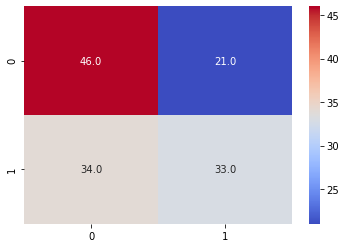

In [14]:
lr_preds = gs_lr.predict(X_test)

cmx = confusion_matrix(y_test, lr_preds)
sns.heatmap(cmx, annot = True, cmap = 'coolwarm', fmt = '.1f');

In [15]:
f1_score(y_test, lr_preds)

0.5454545454545455

Throughout most stages of modeling, the Logistic Regression model was slightly underfit with training scores performing better than testing. Accuracy and f1 scores were generally low.

Grid Search best parameters:
- Regularization: Ridge
- C (inverse strength of regularization): .01
- Class weights: Balanced

**KNN with GridSearch**

In [16]:
# Instantiate model
knn = KNeighborsClassifier()

# Scale data
s = StandardScaler()

# Create pipeline to run scaler and model through
pipe = Pipeline([('s', s),('knn', knn)])

# Select hyperparameters for Grid Search tuning
prms = {'s__with_mean': [True, False],
        's__with_std': [True, False],
        'knn__weights':['uniform', 'distance'],
        'knn__leaf_size':[1,5,10],
        'knn__n_neighbors': [ 3,],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__p':[1,2]
       }

# Grid Search
gs_knn = GridSearchCV(pipe, prms, n_jobs = -1)

# Fit model
gs_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('s', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [1, 5, 10], 'knn__n_neighbors': [3],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         's__with_mean': [True, False],
                         's__with_std': [True, False]})

In [17]:
# Best parameters after Grid Search

gs_knn.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 10,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'uniform',
 's__with_mean': True,
 's__with_std': False}

In [18]:
# Accuracy score

gs_knn.best_score_

0.607275436932665

In [19]:
# Generate predictions

knn_preds = gs_knn.predict(X_test)

In [20]:
# Accuracy of training set

gs_knn.score(X_train, y_train)

0.6897689768976898

In [21]:
#Accuracy on testing set

gs_knn.score(X_test, y_test)

0.5

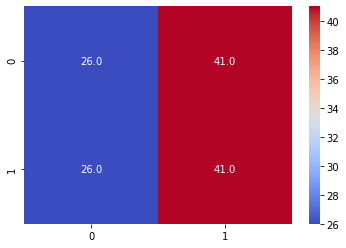

In [22]:
cmx = confusion_matrix(y_test, knn_preds)
sns.heatmap(cmx, annot = True, fmt = '.1f', cmap = 'coolwarm');

In [23]:
 f1_score(y_test, knn_preds)

0.5503355704697986

The KNN model was very overfit, however, unlike the logistic regression model, it was better at predicting the target. The f1 scores are higher and the confusion matrix shows greater values for true positives/negatives than false positives/negatives.

**Random Forest**

In [24]:
#Instantiate model

rf = RandomForestClassifier(random_state = 42)

# Parameters for GridSearchCV

prms = {'bootstrap': [True, False],
        'n_estimators': [5, 10, 100],
        'criterion': ["gini", "entropy"],
        'min_samples_split': [3, 5, 8, 12, 50],
        'class_weight': ['balanced', 'balanced_subsample']}

# Grid search
gs_rf = GridSearchCV(rf, prms, n_jobs = -1)

# Fit model on training data
gs_rf.fit(X_train, y_train)

# Best parameters from GridSearchCV
gs_rf.best_params_

{'bootstrap': True,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'min_samples_split': 8,
 'n_estimators': 100}

In [25]:
gs_rf.best_score_

0.6222056631892697

In [26]:
gs_rf_preds = gs_rf.predict(X_test)

In [27]:
gs_rf.score(X_train, y_train)

0.7788778877887789

In [28]:
gs_rf.score(X_test, y_test)

0.6492537313432836

In [29]:
f1_score(y_test, gs_rf_preds)

0.6356589147286821

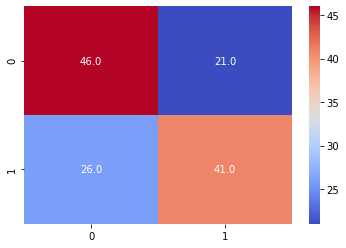

In [30]:
cmx = confusion_matrix(y_test, gs_rf_preds)
sns.heatmap(cmx, annot = True, fmt = '.1f', cmap = 'coolwarm');

Random forest had the best performance. The model was still overfit but not as much as KNN. It also had higher accuracy but worse f1 due to its high false positives. The confusion matrix shows higher values for true positives/negatives than false positives/negatives.

Grid Searched Best Parameters:
- bootstrap: True
- criterion: gini
- min_samples_split: 8
- n_estimators: 100